In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

filepath = 'booksummaries/booksummaries.txt'

In [42]:

df = pd.read_csv(filepath,delimiter='\t')
df.columns = ['WikipediaID', 'Freebase ID', 'Book title', 'Book author', 'Publication date', 'Genres', 'Plot summary']

duplicate = df[df.duplicated()]
print("duplicated titles:", duplicate.shape[0])

df.drop(['WikipediaID', 'Freebase ID', 'Book author', 'Publication date'], axis = 1, inplace = True)
# display(df)       

duplicated titles: 0


In [43]:

df = df[df['Genres'].notna()]
df['Book title'] = df['Book title'].astype(str)
df['Genres'] = df['Genres'].astype(str)
df['Plot summary'] = df['Plot summary'].astype(str)

df = df[~df['Genres'].str.contains('iction') | ~df['Genres'].str.contains('ovel')]
# df = df[~df['Genres'].str.contains('iction') | ~df['Genres'].str.contains('antasy')]
df = df[~df['Genres'].str.contains('orror') | ~df['Genres'].str.contains('hildren')]

df.loc[df['Genres'].str.contains('hildren', na = False), 'Genres'] = 'Children'
df.loc[df['Genres'].str.contains('antasy', na = False), 'Genres'] = 'Fantasy'
df.loc[df['Genres'].str.contains('iography', na = False), 'Genres'] = 'Biography'
df.loc[df['Genres'].str.contains('orror', na = False), 'Genres'] = 'Horror'
df.loc[df['Genres'].str.contains('ovel', na = False), 'Genres'] = 'Novel'
df.loc[df['Genres'].str.contains('ystery', na = False), 'Genres'] = 'Mystery'
df.loc[df['Genres'].str.contains('iction', na = False), 'Genres'] = 'Fiction'

df = df[~df['Genres'].str.contains('{')]

df.reset_index(drop=True,inplace = True)


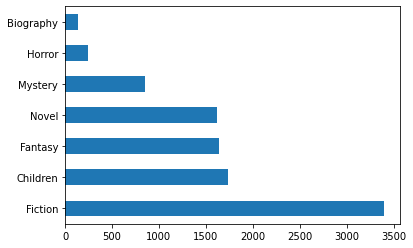

Fiction      3398
Children     1740
Fantasy      1639
Novel        1621
Mystery       850
Horror        248
Biography     138
Name: Genres, dtype: int64


,Book title,Genres,Plot summary
0,A Fire Upon the Deep,Fantasy,The novel posits that space around the Milky ...
1,All Quiet on the Western Front,Novel,"The book tells the story of Paul Bäumer, a Ge..."
2,A Wizard of Earthsea,Children,"Ged is a young boy on Gont, one of the larger..."
3,Blade Runner 3: Replicant Night,Fiction,"Living on Mars, Deckard is acting as a consul..."
4,Blade Runner 2: The Edge of Human,Fiction,Beginning several months after the events in ...
...,...,...,...
9629,Gates of Paradise,Fiction,"A novel about Annie Stonewall, the daughter o..."
9630,The Third Lynx,Fiction,The story starts with former government agent...
9631,Remote Control,Fiction,The series follows the character of Nick Ston...
9632,Transfer of Power,Fiction,The reader first meets Rapp while he is doing...


In [44]:
values = df['Genres'].value_counts()

values.plot(kind='barh')
plt.show()
print(values)

display(df)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english').fit(df['Plot summary'])
bag_of_words = vectorizer.transform(df['Plot summary'])

sum_words = bag_of_words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

display(words_freq)

[('time', 7115),
 ('new', 6209),
 ('life', 5787),
 ('father', 5411),
 ('book', 5068),
 ('man', 4942),
 ('story', 4709),
 ('world', 4639),
 ('family', 4483),
 ('finds', 4356),
 ('old', 4331),
 ('later', 4274),
 ('novel', 4228),
 ('home', 4210),
 ('mother', 4202),
 ('tells', 4093),
 ('death', 3975),
 ('house', 3949),
 ('years', 3921),
 ('help', 3897),
 ('people', 3855),
 ('way', 3731),
 ('takes', 3692),
 ('day', 3482),
 ('young', 3415),
 ('war', 3396),
 ('begins', 3360),
 ('city', 3249),
 ('named', 3124),
 ('love', 3027),
 ('away', 3015),
 ('eventually', 2947),
 ('soon', 2939),
 ('return', 2894),
 ('goes', 2883),
 ('does', 2869),
 ('killed', 2804),
 ('make', 2791),
 ('like', 2776),
 ('night', 2773),
 ('friend', 2761),
 ('son', 2720),
 ('king', 2719),
 ('end', 2691),
 ('children', 2617),
 ('school', 2599),
 ('called', 2598),
 ('woman', 2591),
 ('just', 2571),
 ('ship', 2570),
 ('wife', 2560),
 ('having', 2547),
 ('group', 2485),
 ('place', 2480),
 ('year', 2476),
 ('earth', 2450),
 ('esca

In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(bag_of_words, df['Genres'], test_size=0.3)
text_classifier = MultinomialNB()
text_classifier.fit(X_train, Y_train)

print(text_classifier.score(X_test, Y_test))

0.638187478381183


In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

tfidf_transformer = TfidfTransformer()
word_count_tfidf = tfidf_transformer.fit_transform(bag_of_words)

X_train, X_test, y_train, y_test = train_test_split(word_count_tfidf, df['Genres'], test_size=0.3)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

print(nb_classifier.score(X_test, y_test))

svm_classifier = SGDClassifier(loss='squared_hinge', penalty='l2',
                        alpha=1e-3, random_state=42,
                        max_iter=5, tol=None)

svm_classifier.fit(X_train, y_train)
print(svm_classifier.score(X_test, y_test))

0.3946731234866828
0.6226219301279834


In [48]:
# from sklearn.pipeline import Pipeline

# X_train, X_test, y_train, y_test = train_test_split(df['Plot summary'], df['Genres'], test_size=0.3)

# nb_pipeline = Pipeline([
#     ('vect', CountVectorizer(stop_words='english')),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultinomialNB())
# ])

# nb_pipeline.fit(X_train, y_train)
# print(nb_pipeline.score(X_test, y_test))

# svm_pipeline = Pipeline([
#     ('vect', CountVectorizer(stop_words='english')),
#     ('tfidf', TfidfTransformer()),
#     ('clf', SGDClassifier(loss='hinge', penalty='l2',
#                         alpha=1e-3, random_state=42,
#                         max_iter=5, tol=None))
# ])

# svm_pipeline.fit(X_train, y_train)
# print(svm_pipeline.score(X_test, y_test))